Import all libraries

In [71]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout

Check GPU

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [23]:
BATCH_SIZE = 128
TARGET_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3) 

Load dataset

In [24]:
dataset_path = "/kaggle/input/gender-dataset/Dataset/"

train_dir = os.path.join(dataset_path, 'Train')
test_dir = os.path.join(dataset_path, 'Test')
val_dir = os.path.join(dataset_path, 'Validation')

# **Data preprocessing & augmentation**

In [26]:
train_datagen = ImageDataGenerator(rescale = 1./255,
      rotation_range=250,
      shear_range=0.2,
      zoom_range=0.15,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator( rescale = 1.0/255)

In [51]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = BATCH_SIZE,
                                                    class_mode = 'binary',
                                                    target_size = TARGET_SIZE )     

validation_generator =  test_datagen.flow_from_directory(val_dir,
                                                        batch_size  = BATCH_SIZE,
                                                        class_mode  = 'binary',
                                                        target_size = TARGET_SIZE)

test_generator =  test_datagen.flow_from_directory(test_dir,
                                                        batch_size  = BATCH_SIZE,
                                                        class_mode  = 'binary',
                                                        target_size = TARGET_SIZE)

Found 160000 images belonging to 2 classes.
Found 22598 images belonging to 2 classes.
Found 20001 images belonging to 2 classes.


Pretrained Model **VGG16**

In [28]:
base_model = tf.keras.applications.VGG16(input_shape=INPUT_SHAPE,
                                         include_top=False,
                                         weights="imagenet")

Freeze layer

In [29]:
for layer in base_model.layers:
    layer.trainable=False

Add the output of the last layer.

In [30]:
model = Sequential()

model.add(base_model)
model.add(Flatten())
model.add(Dense(64 , activation='relu'))
model.add(Dropout(.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Compile model

In [31]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Callbacks

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=2,
                               restore_best_weights=True)  


# **Training model**

In [32]:
history = model.fit(train_generator,
                    epochs=5, 
                    validation_data=validation_generator,
                    verbose=1)

Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2140s 2s/step - accuracy: 0.8282 - loss: 0.3916 - val_accuracy: 0.9130 - val_loss: 0.2093
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2107s 2s/step - accuracy: 0.8917 - loss: 0.2576 - val_accuracy: 0.9136 - val_loss: 0.2123
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2141s 2s/step - accuracy: 0.8966 - loss: 0.2465 - val_accuracy: 0.9157 - val_loss: 0.2043
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2147s 2s/step - accuracy: 0.9022 - loss: 0.2361 - val_accuracy: 0.9220 - val_loss: 0.1938
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2163s 2s/step - accuracy: 0.9046 - loss: 0.2283 - val_accuracy: 0.9193 - val_loss: 0.2020


Plot for accuracy and loss trends.

In [37]:
def plot_image(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)
    plt.figure()
    
    plt.show()
    
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend(loc=0)
    plt.figure()
    
    plt.show()

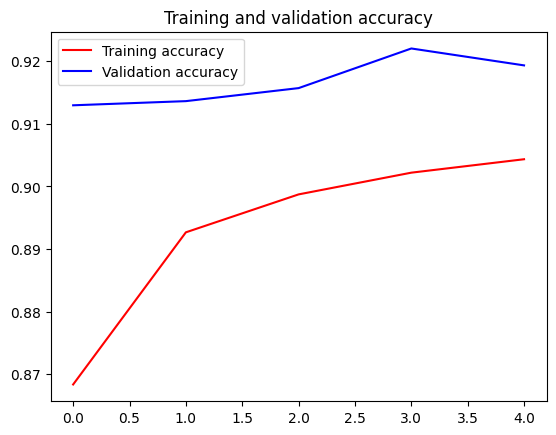

<Figure size 640x480 with 0 Axes>

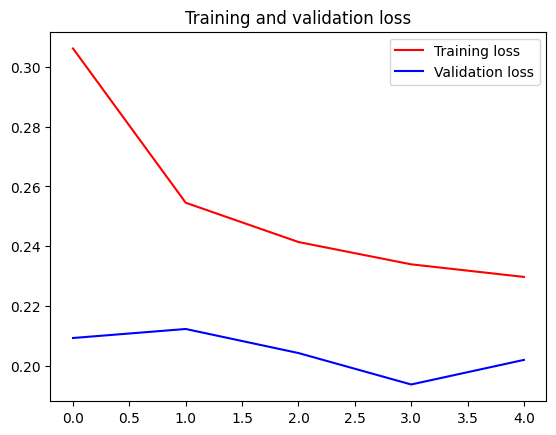

<Figure size 640x480 with 0 Axes>

In [40]:
plot_image(history)

# **Model Evaluation**

Confussion Matrix

157/157 ━━━━━━━━━━━━━━━━━━━━ 106s 679ms/step
True classes length: 20001
Predicted classes length: 20001


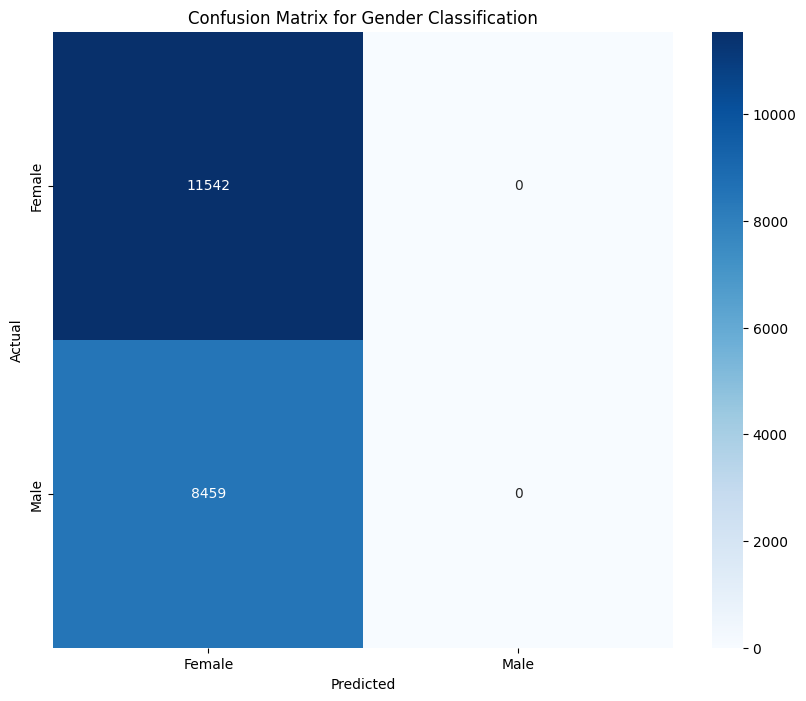

In [67]:
# Generate predictions
predicted_classes = model.predict(test_generator, verbose=1)

# Get true labels
true_classes = test_generator.classes  # Ground truth labels

# Check that lengths match
print(f"True classes length: {len(true_classes)}")
print(f"Predicted classes length: {len(predicted_classes)}")

# Ensure the lengths match before calling confusion_matrix
if len(true_classes) == len(predicted_classes):
    # Generate confusion matrix
    conf_matrix = confusion_matrix(true_classes, predicted_classes)

    # Visualize confusion matrix using heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix for Gender Classification')
    plt.show()
else:
    print("Mismatch in the number of samples between true classes and predicted classes.")


Classification Report

In [70]:
print(classification_report(true_classes, predicted_classes))

              precision    recall  f1-score   support

           0       0.58      1.00      0.73     11542
           1       0.00      0.00      0.00      8459

    accuracy                           0.58     20001
   macro avg       0.29      0.50      0.37     20001
weighted avg       0.33      0.58      0.42     20001



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Save history data to csv

In [73]:
history_data = {
    'epoch': range(1, len(history.history['loss']) + 1),
    'train_loss': history.history['loss'],
    'train_accuracy': history.history['accuracy'],
    'val_loss': history.history['val_loss'],
    'val_accuracy': history.history['val_accuracy']
}

history_df = pd.DataFrame(history_data)

print(history_df)

history_df.to_csv('training_history.csv', index=False)

   epoch  train_loss  train_accuracy  val_loss  val_accuracy
0      1    0.306101        0.868381  0.209327      0.912957
1      2    0.254530        0.892675  0.212339      0.913621
2      3    0.241407        0.898731  0.204297      0.915700
3      4    0.233949        0.902200  0.193792      0.922028
4      5    0.229744        0.904344  0.202006      0.919329


Save model

In [ ]:
# model.save('gender_tl_vgg16.h5')